In [1]:
from tqdm import tqdm 
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from utils.base import eval_accuracy
from utils.base import get_correct_predictions_subset
from utils.data import create_butterfly_dataset
from utils.data import create_imagenet_dataset
from model.butterfly_classifier import DenseNet121
from algo.attacker import adversarial_generator
from torch.utils.data import DataLoader
import torch.nn.functional as F
from utils.base import quick_predict
from algo.attacker import PIA_adversarial_generator
from algo.defender import PartialInfo
from tqdm import trange
from algo.defender import AAAProtectedClassifier

# (0) Download Butterfly 

In [ ]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species

In [ ]:
import zipfile
with zipfile.ZipFile('butterfly-images40-species.zip', 'r') as zip_ref:
    zip_ref.extractall('data/butterfly')

# (1) Process Butterfly Data

In [2]:
trainset, testset, normal_mapping, reverse_mapping, sample_img_dataset = create_butterfly_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

# (2) Import Classifier

In [3]:
model = DenseNet121(num_classes=len(normal_mapping)).to('cuda')
model.load_state_dict(torch.load('./model/states/butterfly_classifier.pth'))

<All keys matched successfully>

# (3) Evaluate Untargeted Adversarial Examples

We also subset the parts where the model could provide correct predictions to attack

In [4]:
model.eval()
accuracy, correct_subset = get_correct_predictions_subset(model, testset, batch_size=100)
print('Accuracy on test set is {:.4f}'.format(accuracy))
print('Number of correctly predicted samples:', len(correct_subset))

Accuracy on test set is 0.9640
Number of correctly predicted samples: 482


# (4) Parameter Definition

In [5]:
# attacker params
batch_size = 32
query_limit = 30000 # max attack limit 
LO_query_limit = 500000 # max attack limit 
search_var = 1e-3 # amount to perturb the input image
sample_num = 50 # 2*sample_num for estimating gradient
bound = 0.1 # the l-infinity distance between the adversarial example and the input image
# partial information paramters + lebel-only parameters
epsilon = 0.5 # initial searching range from the target image
delta = 0.01 # rate to decrease epsilon
eta_max = 0.02 # maximum learning rate
eta_min = 0.01 # minimum learning rate
k = 5 # information access
# label-only parameter
mu = 0.001 # radius for sampling ball
m = 50 # 2*number of sample for proxy score
#correct_subset_loader = DataLoader(correct_subset, batch_size = batch_size, shuffle = False)
correct_subset_loader = DataLoader(correct_subset, batch_size = 5, shuffle = False)
lr = 0.01

In [75]:
# defender params
alpha=1
tau=10
kappa=100
T=1
beta=5
lr=0.1

model.eval()
protected_model = AAAProtectedClassifier(model=model, alpha=alpha, tau=tau, kappa=kappa, T=T, beta=beta, lr=lr, AAA_type='linear')

# (5) Query-Limited Setting

In [77]:
from utils.base import quick_predict

protected_model.to('cuda')
protected_model.eval()

success_count = 0
query_counts = []
adv_images = []
count = 0
with torch.no_grad():
    for i in trange(len(correct_subset)):
        count += 1
        images = correct_subset[i][0].unsqueeze(0)
        
        target_classes = torch.tensor(correct_subset[i][1]).view(1).to('cuda')
        adv_image_batch, query_count_batch = adversarial_generator(protected_model, target_classes, images, 
                                                                 search_var, sample_num,
                                                                bound, lr, query_limit)
        query_counts.append(query_count_batch)
        adv_images.append(adv_image_batch)
        
        adv_class = quick_predict(protected_model, adv_image_batch)
        print(quick_predict(protected_model, images) == quick_predict(model, images))
        success_count += (adv_class != target_classes).to(float).sum()
        
        if count == 5:
            break
adv_image_all = torch.concat(adv_images, dim = 0)
query_count_all = torch.concat(query_counts, dim = 0)
torch.save(adv_image_all, "QL_adv_img.pt")
torch.save(query_count_all, "QL_query.pt")
print('Success count is {}, total count is {}, success attack rate is {}'.format(success_count, len(correct_subset), success_count /len(correct_subset) ))

  0%|          | 1/482 [00:01<09:55,  1.24s/it]

tensor([True], device='cuda:0')


  0%|          | 2/482 [00:02<10:11,  1.27s/it]

tensor([True], device='cuda:0')


  1%|          | 3/482 [00:23<1:20:41, 10.11s/it]

tensor([True], device='cuda:0')


  1%|          | 4/482 [00:44<1:55:22, 14.48s/it]

tensor([True], device='cuda:0')


  1%|          | 4/482 [00:45<1:30:52, 11.41s/it]

tensor([True], device='cuda:0')
Success count is 3.0, total count is 482, success attack rate is 0.006224066390041494


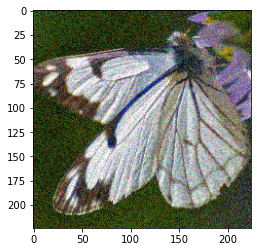

In [61]:
import matplotlib.pyplot as plt
plt.imshow(adv_image_batch[0].detach().cpu().transpose(0,2))

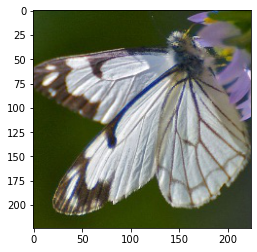

In [62]:
plt.imshow(images[0].detach().cpu().transpose(0,2))

# (6) Partial-Information Setting

In [78]:
success_count_PIA = 0
query_counts_PIA = []
adv_images_PIA = []
count = 0
with torch.no_grad():
    for i in trange(len(correct_subset)):
        
        images = correct_subset[i][0].unsqueeze(0)
        # images = batch[0]
        adv_image_batch, query_count_batch = PIA_adversarial_generator(protected_model, images, sample_img_dataset,
                                                                      epsilon, delta, search_var,
                                                                      sample_num, eta_max, eta_min,
                                                                      bound, k, query_limit, label_only = False)
        query_counts_PIA.append(query_count_batch)
        adv_images_PIA.append(adv_image_batch)
        
        
        reach_bound = (query_count_batch < query_limit).to('cuda')
        successful_attack = (quick_predict(protected_model, adv_image_batch) != correct_subset[i][1]).to('cuda')
        success_count_PIA += (successful_attack * reach_bound).to(int).sum()
        
        
adv_image_all_pia = torch.concat(adv_images_PIA, dim = 0)
query_count_all_pia = torch.concat(query_counts_PIA, dim = 0)
torch.save(adv_image_all_pia, "PIA_adv_img.pt")
torch.save(query_count_all_pia, "PIA_query.pt")
print('Success count is {}, total count is {}, success attack rate is {}'.format(success_count_PIA, len(correct_subset), success_count /len(correct_subset) ))

  0%|          | 1/482 [00:14<1:54:33, 14.29s/it]

tensor([True], device='cuda:0')


  0%|          | 2/482 [00:30<2:05:37, 15.70s/it]

tensor([True], device='cuda:0')


  1%|          | 3/482 [00:45<2:00:54, 15.14s/it]

tensor([True], device='cuda:0')


  1%|          | 4/482 [00:59<1:58:03, 14.82s/it]

tensor([True], device='cuda:0')


  1%|          | 5/482 [01:16<2:02:45, 15.44s/it]

tensor([True], device='cuda:0')


  1%|          | 6/482 [01:30<1:58:39, 14.96s/it]

tensor([True], device='cuda:0')


  1%|▏         | 7/482 [01:46<2:02:23, 15.46s/it]

tensor([True], device='cuda:0')


  2%|▏         | 8/482 [02:08<2:16:35, 17.29s/it]

tensor([True], device='cuda:0')


  2%|▏         | 9/482 [02:28<2:24:59, 18.39s/it]

tensor([True], device='cuda:0')


  2%|▏         | 9/482 [02:42<2:22:30, 18.08s/it]

tensor([True], device='cuda:0')
Success count is 10, total count is 482, success attack rate is 0.006224066390041494


# (7) Label-only Setting

In [ ]:
success_count_LO = 0
query_counts_LO = []
adv_images_LO = []

with torch.no_grad():
    for i in trange(10):
        images = correct_subset[i][0].unsqueeze(0)
        adv_image_batch, query_count_batch = PIA_adversarial_generator(model, images, sample_img_dataset,
                                                                      epsilon, delta, search_var,
                                                                      sample_num, eta_max, eta_min,
                                                                      bound, k, query_limit=LO_query_limit, label_only = True, mu = mu, m = m) # different query_limit
        query_counts_LO.append(query_count_batch)
        adv_images_LO.append(adv_image_batch)
        
        reach_bound = (query_count_batch < LO_query_limit).to('cuda')
        successful_attack = (quick_predict(model, adv_image_batch) != correct_subset[i][1]).to('cuda')
        success_count_LO += (successful_attack * reach_bound).to(int).sum()

        
adv_image_all_lo = torch.concat(adv_images_LO, dim = 0)
query_count_all_lo = torch.concat(query_counts_LO, dim = 0)
torch.save(adv_image_all_lo, "LO_adv_img.pt")
torch.save(query_count_all_lo, "LO_query.pt")
print('Success count is {}, total count is {}, success attack rate is {}'.format(success_count_PIA, 10, success_count /10 ))

# Playground + random testing

In [ ]:
test_img, test_label = testset[3]
test_img = test_img.unsqueeze(0)
initial_img, initial_label = testset[111]
initial_img = initial_img.unsqueeze(0)

In [ ]:
print('Adversarial: predicted class is {}'.format(reverse_mapping[torch.argmax(adv_logits, dim=1).detach().cpu().numpy()[0]]))
print('Original: predicted class is {}'.format(reverse_mapping[torch.argmax(org_logits, dim=1).detach().cpu().numpy()[0]]))

print('Adversarial: logit of true class is {:.2f}'.format(adv_logits[0, test_label]))
print('Original: logit of true class is {:.2f}'.format(org_logits[0, test_label]))

print('Adversarial: probability of true class is {:.2f}'.format(F.softmax(adv_logits, dim=1)[0, test_label]))
print('Original: probability of true class is {:.2f}'.format(F.softmax(org_logits, dim=1)[0, test_label]))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_adv is a PyTorch tensor with shape [C, H, W]
# where C is the number of channels, H is the height, and W is the width.

# Move the tensor to the CPU and convert to a NumPy array
image_np1 = adv_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np1.ndim == 3:
    # Transpose the image for plotting
    image_np1 = image_np1.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np1.max() <= 1.0:
    image_np1 = (image_np1 * 255).astype(np.uint8)


In [ ]:
image_np = test_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np.ndim == 3:
    # Transpose the image for plotting
    image_np = image_np.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np.max() <= 1.0:
    image_np = (image_np * 255).astype(np.uint8)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
image_np2 = initial_img.squeeze().cpu().detach().numpy()

# If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
if image_np2.ndim == 3:
    # Transpose the image for plotting
    image_np2 = image_np2.transpose(1, 2, 0)

# If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
if image_np2.max() <= 1.0:
    image_np2 = (image_np2 * 255).astype(np.uint8)

# Plot the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np1)
plt.title('Adversarial Image_processing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_np2)
plt.title('Original Image')
plt.axis('off')


In [2]:
trainset, testset, normal_mapping, reverse_mapping, sample_img_dataset = create_imagenet_dataset(img_reshape=(3, 224, 224), num_classes = 20)

In [3]:
from utils.base import train_classifier
from torch.utils.data import DataLoader
from torch import nn
import torch

# Params
batch_size=100
lr = 0.0001
device='cuda'

# Data loader
train_loader = DataLoader(dataset=trainset, batch_size=batch_size)
test_loader = DataLoader(dataset=testset, batch_size=batch_size)

In [4]:
class Inception(nn.Module):
    
    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=11):
        super(Inception, self).__init__()
        
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)
        
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        
        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        
        x = self.linear(x)
        
        return x, y, z
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class InceptionBlock(nn.Module):
    
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()
        
        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)
        
        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)  
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)
        
        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)
         
    def forward(self, x):
        x1 = self.one_by_one(x)
        
        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)
        
        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)
        
        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)
        
        x = torch.cat([x1, x2, x3, x4], 1)
        return x
class Auxiliary(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
model = Inception(num_classes=20)
model = model.to('cuda')

In [12]:
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    import time
    import copy
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train']: #, 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    if phase == 'train': # Backward + optimize only if in training phase
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                    
                    if phase == 'val':
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [14]:
model, _ = train_model(model, {"train": train_loader}, criterion, optimizer, epochs)

Epoch 0/49
----------
train Loss: 4.0827 Acc: 0.2560

Epoch 1/49
----------
train Loss: 3.3448 Acc: 0.3886

Epoch 2/49
----------
train Loss: 2.8830 Acc: 0.4746

Epoch 3/49
----------
train Loss: 2.4934 Acc: 0.5523

Epoch 4/49
----------
train Loss: 2.1464 Acc: 0.6304

Epoch 5/49
----------
train Loss: 1.8468 Acc: 0.6949

Epoch 6/49
----------
train Loss: 1.6660 Acc: 0.7294

Epoch 7/49
----------
train Loss: 1.5224 Acc: 0.7574

Epoch 8/49
----------
train Loss: 1.3635 Acc: 0.7918

Epoch 9/49
----------
train Loss: 1.1978 Acc: 0.8280

Epoch 10/49
----------
train Loss: 1.0177 Acc: 0.8688

Epoch 11/49
----------
train Loss: 0.8641 Acc: 0.8956

Epoch 12/49
----------
train Loss: 0.7361 Acc: 0.9241

Epoch 13/49
----------
train Loss: 0.6514 Acc: 0.9355

Epoch 14/49
----------
train Loss: 0.5540 Acc: 0.9514

Epoch 15/49
----------
train Loss: 0.4534 Acc: 0.9696

Epoch 16/49
----------
train Loss: 0.3682 Acc: 0.9810

Epoch 17/49
----------
train Loss: 0.3011 Acc: 0.9894

Epoch 18/49
--------

In [33]:
model(trainset[1][0].unsqueeze(0).to('cuda'))

(tensor([[ 0.2959, -0.2882,  0.0228,  0.2408,  0.0149, -0.4518,  0.3257, -0.3219,
           0.2708,  0.1396, -0.5786]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.7074, -0.0497, -0.1725, -0.4902, -0.0135, -0.2188, -0.1085, -0.1735,
           0.0167,  0.1769, -0.0511]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[-0.2838, -0.4180, -0.3491,  0.2687, -0.0706,  0.0766, -0.2629,  0.1114,
           0.2106, -0.4020,  0.0440]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [15]:
torch.save(model.state_dict(), 'imagenetclassifier.pth')